<a href="https://colab.research.google.com/github/choltz95/density-estimation/blob/main/DS_manifold_with_boundary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install graphlearning jaxopt

In [ ]:
#@title imports
import jax
from jax import numpy as jnp
from jax import jit, grad, vmap
from jax.config import config; config.update("jax_enable_x64", True)

from jaxopt import GaussNewton

import numpy as np
import graphlearning as gl
import matplotlib.pyplot as plt

import scipy
from scipy import sparse, spatial

from tqdm.notebook import tqdm

In [ ]:
def sinkhorn(K, maxiter=100, delta=1e-10, eps=1e-8):
    """https://epubs.siam.org/doi/pdf/10.1137/20M1342124 """
    D = np.array(np.sum(K,0)).squeeze()
    d0 = 1./(D + eps)
    dp = 1./(K@d0 + eps)
    d = 1./(K@dp + eps)
    tau = 2
    for tau in tqdm(range(maxiter)):
        d = 1. / (K.T@dp + eps)
        dr = np.sqrt(dp * d)
        if np.max(np.abs(dp / d - 1)) < delta:
          break
        dp = d
    K = scipy.sparse.diags(dr) @ K @ scipy.sparse.diags(dr)
    return K, d

In [ ]:
N = 10000
m = 2
length = np.sqrt(np.random.uniform(0, 1, N))
angle = np.pi * np.random.uniform(0, 2, N)

x = length * np.cos(angle)
y = length * np.sin(angle)
X = np.stack([x,y],1) + np.random.normal(loc=0,scale=0.2,size=(N,2))

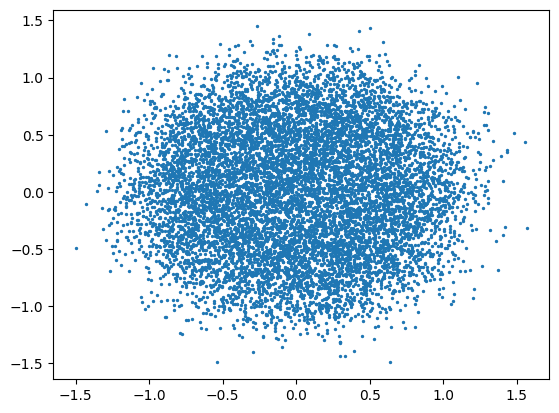

In [ ]:
plt.scatter(X[:,0],X[:,1], s=2)
plt.show()

In [ ]:
def __weights__(dists,h):
    weights = np.exp(-dists/(h))
    fzero = 1
    return weights, fzero

def epsilon_ball(data, h, epsilon, epsilon_f=1, eta=None, prod=False):
    """Construct a sparsified KDE (an epsilon-ball graph) """
    n = data.shape[0]  #Number of points

    #Rangesearch to find nearest neighbors
    Xtree = spatial.cKDTree(data)
    M = Xtree.query_pairs(epsilon)
    M = np.array(list(M))

    #Differences between points and neighbors
    V = data[M[:,0],:] - data[M[:,1],:]
    dists = np.sqrt(np.sum(V*V,axis=1))
    weights, fzero = __weights__(dists,h)

    if prod:
      # return K(||Xi - Xj|| / h) (Xi - Xj)
      weights = np.expand_dims(weights,1) * V
      weights = np.concatenate((-weights,weights))
      return weights
    else:
      # return K(||Xi - Xj|| / h)
      weights = np.concatenate((weights,weights))

    M1 = np.concatenate((M[:,0],M[:,1]))
    M2 = np.concatenate((M[:,1],M[:,0]))

    #Construct sparse matrix and convert to Compressed Sparse Row (CSR) format
    W = sparse.coo_matrix((weights, (M1,M2)),shape=(n,n))

    return W.tocsr()

In [ ]:
"""Construct kernel kij =  exp (sqrt(||xi - xj||^2 / h^2)) """
h = 0.2
eps = 1.0
K1 = epsilon_ball(X, h=h, epsilon=eps, prod=False)

In [ ]:
#K1 = sinkhorn(K1)[0]

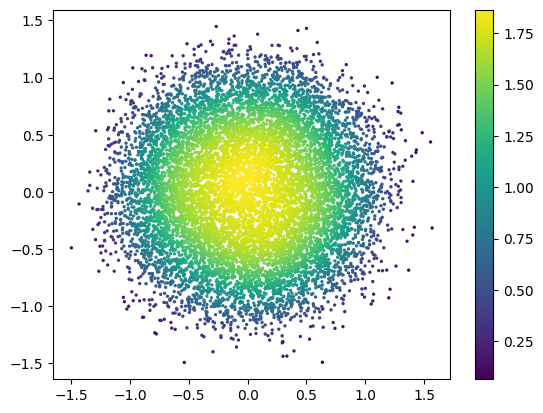

In [ ]:
fn = 1/(N*h**m)*np.array(K1.sum(1))
plt.scatter(X[:,0],X[:,1], s=2, c=fn)
plt.colorbar()
plt.show()

In [ ]:
from jax.experimental.sparse import BCOO
K1bcoo = BCOO.from_scipy_sparse(K1)
indices = K1bcoo.indices
data = K1bcoo.data

In [ ]:
"""Construct kernel kij =  K*(xi - xj)) """
@jit
def munval(ind, data, X):
  i,j = ind
  return data * (X[j] - X[i])

K2 = vmap(munval, in_axes=(0, 0, None))(indices, data, jnp.array(X))
#K2 = epsilon_ball(X, h=h, epsilon=eps, prod=True)
K2 = BCOO((K2, indices), shape=K1bcoo.shape+(2,))
o = jnp.ones(N)
mun = o@K2
mun = 1/(N*h**(m+1))*mun
mun.shape

(10000, 2)

In [ ]:
c = fn / (jnp.sqrt(jnp.pi) * jnp.linalg.norm(mun,axis=1,keepdims=True))
lbbx = h * np.sqrt(np.maximum(0,np.log(c/2)))

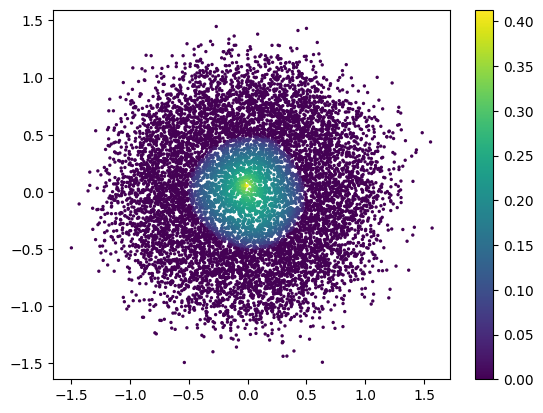

In [ ]:
plt.scatter(X[:,0],X[:,1], s=2, c=lbbx)
plt.colorbar()
plt.show()

In [1]:
"""optimization of bx """
@jit
def F(bx, h, c):
  return (1 + jax.lax.erf(bx / h))*jnp.exp((bx*bx) / (h*h)) - c

x_init = lbbx
gn = GaussNewton(residual_fun=F, maxiter=1000, tol=1e-6, verbose=True)
gn_sol = gn.run(x_init, h=h, c=c).params

NameError: ignored

In [ ]:
 bx = gn_sol
m0 = jax.lax.erf(bx / h)

plt.scatter(X[:,0],X[:,1], s=2, c=(bx))
plt.colorbar()
plt.show()